In [1]:
from pyspark import SparkContext, SparkConf


local="My App"
master="Spark"

#conf = SparkConf().setAppName(local).setMaster(master)
conf = SparkConf().setAppName(local)
sc = SparkContext(conf=conf)


In [2]:
def get_parameter(myrdd, chain):
    """ Parse a line in the ratings dataset
    Args:
        entry (str): a line in the ratings dataset in the form of Competence:Description
    Returns:
        Description
    """
    entry=myrdd.filter(lambda s: chain in s).collect()
    items = entry[0].split(":")
    return items[1]


In [3]:
#load the Competence descriptions then the TD descriptions

import sys
import os

baseDir = os.path.join('data')

inputOrderPath = os.path.join('comp', 'Order.txt')
OrderFileName = os.path.join(baseDir, inputOrderPath)
numPartitions = 1
rawOrderDescriptions = sc.textFile(OrderFileName).repartition(numPartitions)

firstFileName = get_parameter(rawOrderDescriptions,'firstFile')
secondFileName = get_parameter(rawOrderDescriptions, 'secondFile')
outputFileName  = get_parameter(rawOrderDescriptions, 'outputFile')
stopFileName  = get_parameter(rawOrderDescriptions, 'stopwordFile')

print ("Loading ", firstFileName, secondFileName)
print ("Output ", outputFileName)
print ("stopwords ", stopFileName)

numPartitions = 2
inputPath = os.path.join('comp', firstFileName)
competenceFilename = os.path.join(baseDir, inputPath)
print(competenceFilename)
rawDescriptions = sc.textFile(competenceFilename).repartition(numPartitions)

print ("First file: ", rawDescriptions.count())
print (rawDescriptions.take(2))

inputTDPath = os.path.join('comp', secondFileName)
TDFilename = os.path.join(baseDir, inputTDPath)

rawTDDescriptions = sc.textFile(TDFilename).repartition(numPartitions)

print ("Second file: ", rawTDDescriptions.count())
print (rawTDDescriptions.take(2))


Loading  TDCatalogue.csv TDCatalogue.csv
Output  Output.csv
stopwords  StopWords.txt
data/comp/TDCatalogue.csv
First file:  17
['01: Systems Engineering Support::Disciplines related to the interdisciplinary approach governing the total technical and managerial effort required to transform a set of customer needs, expectations, and constraints into a solution and to support that solution throughout its life. Also includes system-/ platform-level testing, configuration management', '011: Operational Analysis::Activities which enable to capture, anticipate and define customer needs, to develop respective scenarios and derive operational concepts with systems demands in response to these needs. This covers analysis of the operational scenario in a system of system context including requirements and functional analysis based on Concept of Operations (ConOps) and Concepts of Use (ConUse)']
Second file:  17
['01: Systems Engineering Support::Disciplines related to the interdisciplinary approa

In [4]:
import re

def removePunctuation(text):
    """Removes punctuation, changes to lower case, and strips leading and trailing spaces.

    Note:
        Only spaces, letters, and numbers should be retained.  Other characters should should be
        eliminated (e.g. it's becomes its).  Leading and trailing spaces should be removed after
        punctuation is removed.

    Args:
        text (str): A string.

    Returns:
        str: The cleaned up string.
    """
    text2=text.lower()
    text3=re.sub(r'[^a-zA-Z0-9 ]', '',text2)
    return(text3.strip())

print (removePunctuation("Hi, 'you!"))

hi you


In [5]:
def get_entries_tuple(entry):
    """ Parse a line in the ratings dataset
    Args:
        entry (str): a line in the ratings dataset in the form of Competence::Description
    Returns:
        tuple: (Competence, Description)
    """
    items = entry.split("::")
    return items[0], items[1]

print (get_entries_tuple("Hi::you!"))

('Hi', 'you!')


In [10]:
sum = lambda x, y : x + y
print(sum(3,4))


TestText='01: Systems Engineering Support::Disciplines related to the interdisciplinary approach governing the total technical and managerial effort required to transform a set of customer needs, expectations, and constraints into a solution and to support that solution throughout its life. Also includes system-/ platform-level testing, configuration management'

print(get_entries_tuple(TestText))
removeP = lambda s: (s[0], removePunctuation(s[1]))
removeP(get_entries_tuple(TestText))

7
('01: Systems Engineering Support', 'Disciplines related to the interdisciplinary approach governing the total technical and managerial effort required to transform a set of customer needs, expectations, and constraints into a solution and to support that solution throughout its life. Also includes system-/ platform-level testing, configuration management')


('01: Systems Engineering Support',
 'disciplines related to the interdisciplinary approach governing the total technical and managerial effort required to transform a set of customer needs expectations and constraints into a solution and to support that solution throughout its life also includes system platformlevel testing configuration management')

In [16]:
#This is the parse of the competences and TDs 

descriptionsNoSplitRDD = (rawDescriptions
                          .filter(lambda s: "::" in s)
                          .map(get_entries_tuple)
                          .map(lambda s: (s[0], removePunctuation(s[1]))))

descriptionsRDD = (descriptionsNoSplitRDD
                   .map(lambda s: (s[0], s[1].split()))
                   .cache())
print('There are %s descriptions in the first datasets' % (descriptionsRDD.count()))
print('Descriptions: %s' % descriptionsRDD.take(2))

TDNoSplitRDD = (rawTDDescriptions
                   .filter(lambda s: "::" in s)
                   .map(get_entries_tuple)
                   .map(lambda s: (s[0], removePunctuation(s[1]))))

TDRDD= (TDNoSplitRDD
            .map(lambda s: (s[0], s[1].split()))
            .cache())

print('There are %s TD in the second datasets' % (TDRDD.count()))
print('TD: %s' % TDRDD.take(2))


There are 17 descriptions in the first datasets
Descriptions: [('01: Systems Engineering Support', ['disciplines', 'related', 'to', 'the', 'interdisciplinary', 'approach', 'governing', 'the', 'total', 'technical', 'and', 'managerial', 'effort', 'required', 'to', 'transform', 'a', 'set', 'of', 'customer', 'needs', 'expectations', 'and', 'constraints', 'into', 'a', 'solution', 'and', 'to', 'support', 'that', 'solution', 'throughout', 'its', 'life', 'also', 'includes', 'system', 'platformlevel', 'testing', 'configuration', 'management']), ('011: Operational Analysis', ['activities', 'which', 'enable', 'to', 'capture', 'anticipate', 'and', 'define', 'customer', 'needs', 'to', 'develop', 'respective', 'scenarios', 'and', 'derive', 'operational', 'concepts', 'with', 'systems', 'demands', 'in', 'response', 'to', 'these', 'needs', 'this', 'covers', 'analysis', 'of', 'the', 'operational', 'scenario', 'in', 'a', 'system', 'of', 'system', 'context', 'including', 'requirements', 'and', 'functional

In [17]:
import re

# remove unwanted words

baseDir = os.path.join('data')
inputPath = os.path.join('cs100', 'lab3')

STOPWORDS_PATH = 'stopwords.txt'

stopfile = os.path.join(baseDir, inputPath, STOPWORDS_PATH)
stopwords = set(sc.textFile(stopfile).collect())
print 'These are the stopwords: %s' % stopwords

#in case it is useful
quickbrownfox = 'A quick brown fox jumps over the lazy dog.'
split_regex = r'\W+'

def tokenize(string):
    """ An implementation of input string tokenization that excludes stopwords
    Args:
        string (str): input string
    Returns:
        list: a list of tokens without stopwords
    """
    string2=string.lower()
    mylist = re.split(split_regex, string2)
    
    for aword in stopwords :
        while mylist.__contains__(aword)>0: 
            mylist.remove(aword)

    while mylist.__contains__('')>0: mylist.remove('')

    return mylist

print "Tokenize:" , tokenize(quickbrownfox) # Should give ['quick', 'brown', ... ]

def removeStopWords (myList):
    aList=[]
    
    for myWord in myList :
        if myWord not in stopwords:
            aList.append(myWord)
    return aList

print "Remove words: ", (removeStopWords([u'description', u'the', u'just']))

def tf(tokens):
    """ Compute TF
    Args:
        tokens (list of str): input list of tokens from tokenize
    Returns:
        dictionary: a dictionary of tokens to its TF values
    """
    dictionary={}
    k=len(tokens)
    for i in tokens: 
        if i in dictionary: 
            dictionary[i]+= 1.0
        else: dictionary[i]=1.0
    
    dictionary
    for j in dictionary:
        dictionary[j]/= k
    return dictionary

print "TF: ", tf(tokenize(quickbrownfox))



SyntaxError: Missing parentheses in call to 'print' (<ipython-input-17-5571a423f745>, line 12)

In [6]:
#Filter the Comeptences and TDs
filteredDescriptionsRDD = (descriptionsRDD
                           .map(lambda (s, v): (s, removeStopWords(v)))
                           .map(lambda (s,v): (s, tf(v)))
                           .cache())

print 'There are %s descriptions in the first datasets' % (filteredDescriptionsRDD.count())
#print 'Descriptions: %s' % filteredDescriptionsRDD.take(3)
print "Biggest record has %s tokens\n" % len(filteredDescriptionsRDD.takeOrdered(1, lambda (x,v): -len(v))[0][1])

filteredTDRDD = (TDRDD
                 .map(lambda (s, v): (s, removeStopWords(v)))
                 .map(lambda (s,v): (s, tf(v)))
                 .cache())

print 'There are %s descriptions in the second datasets' % (filteredTDRDD.count())
#print 'Descriptions: %s' % filteredTDRDD.take(3)
print "Biggest record has %s tokens\n" % len(filteredTDRDD.takeOrdered(1, lambda (x,v): -len(v))[0][1])

crossSmall = (TDNoSplitRDD
              .cartesian(descriptionsNoSplitRDD)
              .cache())

print 'There are %s descriptions in the join dataset' % crossSmall.count()
#print crossSmall.take(2)


There are 104 descriptions in the first datasets
Biggest record has 46 tokens

There are 104 descriptions in the second datasets
Biggest record has 46 tokens

There are 10816 descriptions in the join dataset


There are 811 unique tokens in the small datasets.

Tokens wiht the smallest IDF (differentiating words) [(u'systems', 2.6666666666666665), (u'design', 3.1515151515151514), (u'study', 4.16), (u'includes', 4.333333333333333), (u'engineering', 5.2), (u'system', 6.117647058823529), (u'specific', 6.933333333333334), (u'disciplines', 6.933333333333334), (u'related', 6.933333333333334), (u'methods', 7.428571428571429), (u'technologies', 7.428571428571429)]


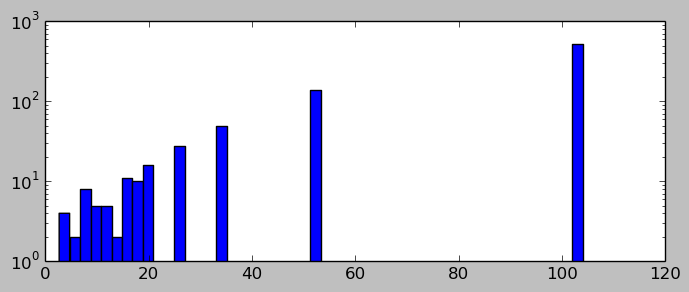

In [7]:
#Conputation of TFIDF dictionnary
def idfs(corpus):
    """ Compute IDF
    Args:
        corpus (RDD): input corpus
    Returns:
        RDD: a RDD of (token, IDF value)
    """
    N = corpus.count()
    uniqueTokens = corpus.map(lambda (s,v): tf(v).keys())
    tokenCountPairTuple = uniqueTokens.flatMap(lambda s:s).map(lambda s: (s, 1)).reduceByKey(lambda a, b: a+b)
    tokenSumPairTuple = tokenCountPairTuple.map(lambda (s,v): (s, float(N) / v))
    return(tokenSumPairTuple)

idfsSmall = idfs(filteredDescriptionsRDD.union(filteredTDRDD))
idfsSmallWeights = idfsSmall.collectAsMap()
uniqueTokenCount = idfsSmall.count()

print 'There are %s unique tokens in the small datasets.\n' % uniqueTokenCount
smallIDFTokens = idfsSmall.takeOrdered(11, lambda s: s[1])
print 'Tokens wiht the smallest IDF (differentiating words)', smallIDFTokens

import matplotlib.pyplot as plt

small_idf_values = idfsSmall.map(lambda s: s[1]).collect()
fig = plt.figure(figsize=(8,3))
plt.hist(small_idf_values, 50, log=True)
pass

In [8]:
def tfidf(tokens, idfs):
    """ Compute TF-IDF
    Args:
        tokens (list of str): input list of tokens from tokenize
        idfs (dictionary): record to IDF value
    Returns:
        dictionary: a dictionary of records to TF-IDF values
    """
    tfs = tf(tokens)
    tfIdfDict = dict(tfs)
    
    for i in tfIdfDict: 
        if i in idfs: 
            tfIdfDict[i]*=idfs[i]
    
    return tfIdfDict


#recSysEng = filteredDescriptionsRDD.filter(lambda x: x[0] == u'010: System Engineering PMT').collect()[0][1]
idfsSmallWeights = idfsSmall.collectAsMap()
#recSysEng_weights = tfidf(recSysEng, idfsSmallWeights)
#print '"System Engineering PMT" has tokens and weights:\n%s' % recSysEng_weights

In [9]:
#Computation of similarities between the competences strings


import math

def dotprod(a, b):
    """ Compute dot product
    Args:
        a (dictionary): first dictionary of record to value
        b (dictionary): second dictionary of record to value
    Returns:
        dotProd: result of the dot product with the two input dictionaries
    """
    
    dotProd=0
    for i in a:
        if i in b: dotProd += a[i]*b[i]
        
    return dotProd

def norm(a):
    """ Compute square root of the dot product
    Args:
        a (dictionary): a dictionary of record to value
    Returns:
        norm: a dictionary of tokens to its TF values
    """
    Norm2=0
    for i in a:
        Norm2 += a[i] * a[i]
    
    Norm= math.sqrt(Norm2)
    return Norm

def cossim(a, b):
    """ Compute cosine similarity
    Args:
        a (dictionary): first dictionary of record to value
        b (dictionary): second dictionary of record to value
    Returns:
        cossim: dot product of two dictionaries divided by the norm of the first dictionary and
                then by the norm of the second dictionary
    """
    return dotprod(a,b)/(norm(a)*norm(b)+0.1)

testVec1 = {'foo': 2, 'bar': 3, 'baz': 5 }
testVec2 = {'foo': 1, 'bar': 0, 'baz': 20 }
dp = dotprod(testVec1, testVec2)
nm = norm(testVec1)
print dp, nm

def cosineSimilarity(string1, string2, idfsDictionary):
    """ Compute cosine similarity between two strings
    Args:
        string1 (str): first string
        string2 (str): second string
        idfsDictionary (dictionary): a dictionary of IDF values
    Returns:
        cossim: cosine similarity value
    """
    w1 = tfidf(tokenize(string1), idfsDictionary)
    w2 = tfidf(tokenize(string2), idfsDictionary)
    return cossim(w1, w2)

cossimAdobe = cosineSimilarity(u'Demonstrated ability to define, implement and maintain engineering processes',
                               u'Ability to consider impact of the Civil and Military Certification regulations and processes',
                               idfsSmallWeights)

print cossimAdobe

cossimAdobe = cosineSimilarity(u'demonstrated ability engineering processes',
                               u'ability to impact of the regulations and processes',
                               idfsSmallWeights)

print cossimAdobe

102 6.16441400297
0.00272000014897
0.0556262299591


In [10]:
def computeSimilarityBroadcast(record):
    """ Compute similarity on a combination record, using Broadcast variable
    Args:
        record: a pair, (google record, amazon record)
    Returns:
        pair: a pair, (google URL, amazon ID, cosine similarity value)
    """
    competence1 = record[0]
    competence2 = record[1]
    competence1Name = competence1[0]
    competence2Name = competence2[0]
    competence1Value = competence1[1]
    competence2Value = competence2[1]
    
    print competence1Name
    print competence1Value
    cs = cosineSimilarity(competence1Value, competence2Value, idfsSmallBroadcast.value)
    return (competence1Name, competence2Name, cs)

idfsSmallBroadcast = sc.broadcast(idfsSmallWeights)
similaritiesBroadcast = (crossSmall
                         .map(lambda s: computeSimilarityBroadcast(s))
                         .cache())

#print "TAKE 1: " , crossSmall.take(1)
#print "TAKE 1[0]" , crossSmall.take(1)[0]

#print crossSmall.take(1)[0][1]
#print crossSmall.take(1)[0][1][0]
#print 'similaritiesBroadcast (crossSmall)', computeSimilarityBroadcast(crossSmall.take(1)[0])
#print similaritiesBroadcast.count()
#print similaritiesBroadcast.take(5)


def similarBroadcast(TDName, CName):
    """ Return similarity value, computed using Broadcast variable
    Args:
        TDName: amazon ID
        CName: google URL
    Returns:
        similar: cosine similarity value
    """
    return (similaritiesBroadcast
            .filter(lambda record: (record[0] == TDName and record[1] == CName))
            .collect()[0][2])

#similarityC1C2Broadcast = similarBroadcast(u'010: System Engineering PMT (Systems Engineering Processes, Methods and Tools)', u'010: System Engineering PMT')
#print 'Requested similarity is %s.' % similarityC1C2Broadcast
#similarityC1C2Broadcast = similarBroadcast(u'010: System Engineering PMT (Systems Engineering Processes, Methods and Tools)', u'010aa: Process Definition & Support')
#print 'Requested similarity is %s.' % similarityC1C2Broadcast



In [11]:
def sortIterable(listOfValues):
    """ Return sorted list, decreasing order, second parameter
    Args:
        list of values
    Returns:
        top 3
    """
    return (sorted(listOfValues, reverse=True)[:3])

testStringRDD = (sc.parallelize([('a', 5), ('b', 7), ('c', 17), ('d', 1)])
                 .map(lambda s: (1, (s[1], s[0])))
                 .groupByKey())
print 'test string is:', testStringRDD.take(1)[0][1]
print 'sorted result is: ', sortIterable(testStringRDD.take(1)[0][1])


print 
sortedSimilaritiesBroadcast = similaritiesBroadcast.takeOrdered(3, lambda (s): s[2])

print "top 3 are: ", sortedSimilaritiesBroadcast
print



    

test string is: <pyspark.resultiterable.ResultIterable object at 0xb09d768c>
sorted result is:  [(17, 'c'), (7, 'b'), (5, 'a')]

top 3 are:  [(u'TD', u'010: System Engineering PMT (Systems Engineering Processes, Methods and Tools)', 0.0), (u'TD', u'012: System Model, Sim & Virtualization (System Modelling, Simulation & Virtualization)', 0.0), (u'TD', u'014: Configuration Management', 0.0)]



In [14]:
mySimilaritiesBroadcast = (similaritiesBroadcast
                           .map(lambda s: (s[0], (s[2], s[1])))
                           .groupByKey()
                          .map(lambda (s, v): (s, sortIterable(v))))


outputPath = os.path.join('Comp', outputFileName)
resultFilename = os.path.join(baseDir, outputPath)
f = open(resultFilename, "w")

myString = ""
for i in mySimilaritiesBroadcast.collect():
    myString=myString+i[0]+'; '
    for j in range (0,3):
        myString = myString+i[1][j][1]+'; '
        myString = myString+repr(int(1000*i[1][j][0]))+';'
    f.write(myString)
    #print myString
    myString = ""

f.close()

03: In-service Support Engineering; 03: In-service Support Engineering; 999;033: Structural Integrity & Health Mgt. (Structural Integrity & Health Management); 267;111: IT Service Management; 78;
13: Guidance, Navigation & Control (GNC); 13: Guidance, Navigation & Control (GNC); 998;133: Navigation; 235;123: Flight Dynamics; 68;
07: Electric, Electronic & Electromag. (Electric, Electronic & Electromagnetic); 07: Electric, Electronic & Electromag. (Electric, Electronic & Electromagnetic); 999;143: Mission & Avionics; 81;055: System Installation Design & Integ (System Installation Design & Integration); 51;
030: Useability / Operability / RAMT; 030: Useability / Operability / RAMT; 999;074: Electr. Power Gen., Distn., Storage (Electrical Power Generation, Distribution, Storage); 46;020: Safety; 22;
021: Environmental Qualification; 021: Environmental Qualification; 998;161: Rig & Test Facility Technology; 138;041: Metallic Materials; 59;
022: Human Factors & Ergonomics; 022: Human Factor